In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-light-detection-dataset/submit_example.json
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/02585.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/02085.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/02880.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/02308.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/01093.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/01045.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/00938.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/01535.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/00074.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/00009.jpg
/kaggle/input/traffic-light-detection-dataset/test_dataset/test_images/00530.jpg
/kaggle/input/traffic-light-detection-datas

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import cv2
import time
import pandas as pd
import numpy as np
import json

from PIL import Image
import torch 
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

DIR_INPUT = '/kaggle/input/traffic-light-detection-dataset/'
DIR_IMAGES = DIR_INPUT + "train_dataset/train_images/"
DIR_IMAGES_TEST = DIR_INPUT + "test_dataset/test_images/"


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
with open("/kaggle/input/traffic-light-detection-dataset/train_dataset/train.json") as f:
    data_dict = json.load(f)

# Create a list containing the data rows of the table
data = []

# Loop through the elements in the annotations list
for annotation in data_dict['annotations']:
    # Get general bounding box information
    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']
    
    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })
    

# Create a DataFrame from a list of data and save it to a CSV file
df = pd.DataFrame(data)
df.to_csv('traffic_lights.csv', index=False)


In [4]:
data_tf = pd.read_csv('/kaggle/working/traffic_lights.csv')

In [5]:
data_tf['filename'] = data_tf['filename'].str.replace('train_images\\\\', '', regex=True)
data_tf.to_csv('traffic_lights_labels.csv', index=False)

In [6]:
df = pd.read_csv('/kaggle/working/traffic_lights_labels.csv')
df

filename    xmin    ymin    xmax    ymax  color
0     00001.jpg  1026.5   741.8  1077.5   910.9    red
1     00002.jpg  1418.7  1136.8  1428.3  1149.4    red
2     00003.jpg  2574.3   868.7  2632.3   887.1    red
3     00003.jpg  2252.1   899.6  2300.8   918.7  green
4     00004.jpg   833.3  1163.2   843.6  1184.8  green
...         ...     ...     ...     ...     ...    ...
9417  03000.jpg    78.8  1001.7   107.7  1033.1    red
9418  03000.jpg  1234.8  1058.4  1251.0  1096.4  green
9419  03000.jpg  1264.9  1068.1  1287.6  1086.1  green
9420  03000.jpg  1296.0  1056.6  1311.7  1096.2  green
9421  03000.jpg  1346.5  1057.5  1360.8  1096.6  green

[9422 rows x 6 columns]

In [7]:
unq_values = df["filename"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unq_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  9422
Unique Images:  2470

> Null Values in each column <
filename    0
xmin        0
ymin        0
xmax        0
ymax        0
color       0
dtype: int64


In [8]:
classes = df["color"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  3

> Classes <
 ['red' 'green' 'yellow']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


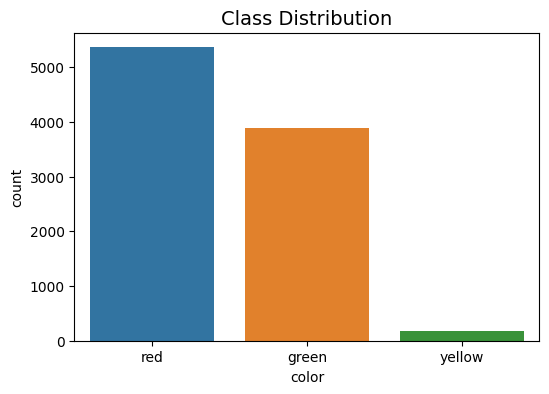

In [9]:
plt.figure(figsize=(6, 4))
plt.title('Class Distribution', fontsize= 14)
sns.countplot(x = "color", data = df);

In [29]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_img(image_name):
    
    fig, ax = plt.subplots(3, 1, figsize=(14, 18))  # Changed the number of subplots to 3
    ax = ax.flatten()
    
    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image.copy()  # Make a copy to preserve the original image
    
    # Plot the original image
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    # Plot the image with bounding boxes
    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['color']
        if label == 'red':
            color_brg = (255, 0, 0)
        elif label == 'green':
            color_brg = (0, 255, 0)
        elif label == 'yellow':
            color_brg = (0, 255, 255)
        
        cv2.rectangle(image2, (int(x1), int(y1)), (int(x2), int(y2)), color_brg, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1), int(y1-10)), font, 1, color_brg, 2)
    
    ax[1].set_title('Image with Boundary Box')
    ax[1].imshow(image2)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Plot the grayscale image
    ax[2].set_title('Grayscale Image')
    ax[2].imshow(gray_image, cmap='gray')

    plt.show()


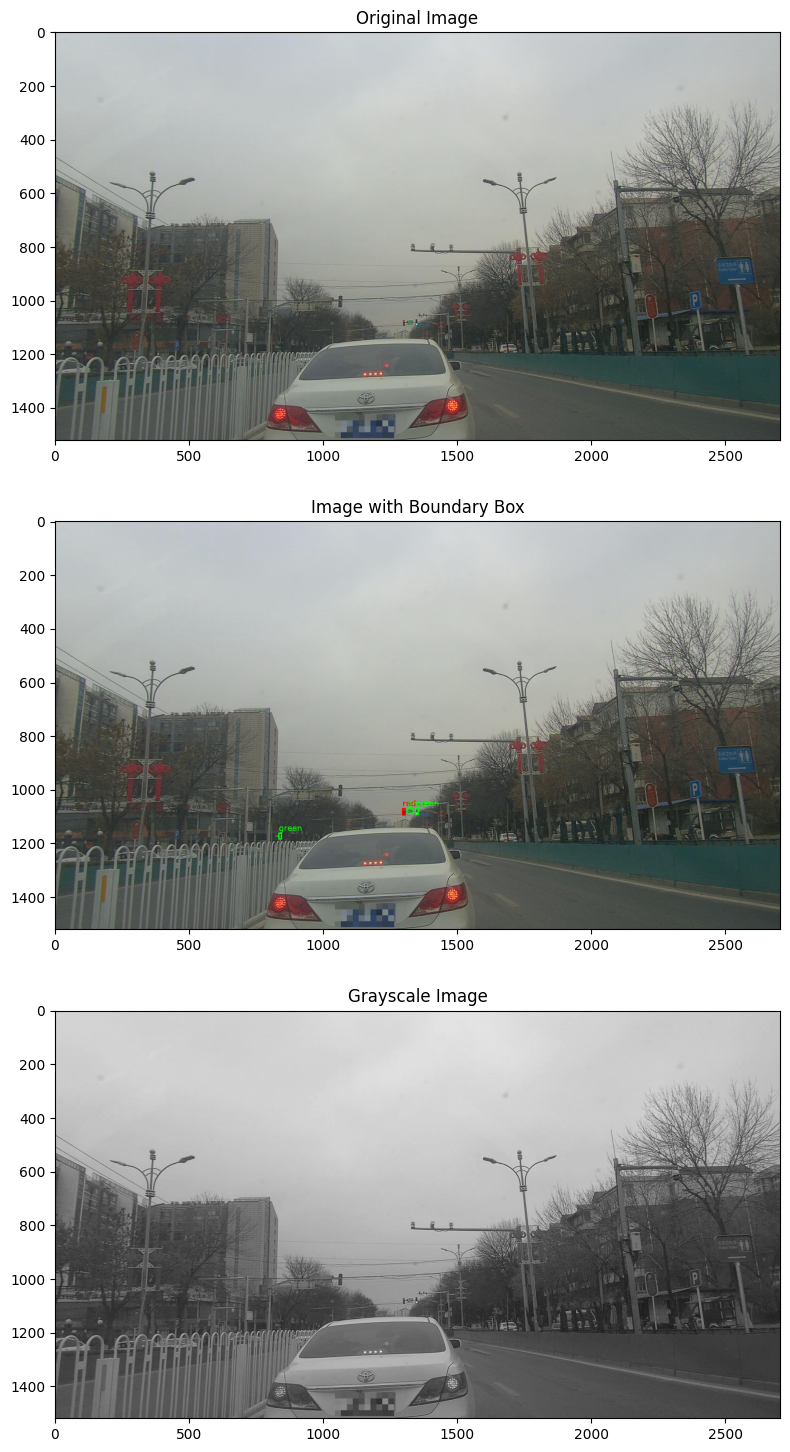

In [30]:
plot_img("00004.jpg")

In [100]:
def plot_img(image_name):
    
    fig, ax = plt.subplots(4, 1, figsize=(14, 18))  # Changed the number of subplots to 2x2
    ax = ax.flatten()
    
    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)
    
    # Load the original image
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image_with_boxes = image.copy()  # Make a copy to preserve the original image
    
    # Plot the original image
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    # Plot the image with bounding boxes
    for idx, row in bbox.iterrows():
        x1 = int(row['xmin'])
        y1 = int(row['ymin'])
        x2 = int(row['xmax'])
        y2 = int(row['ymax'])
        label = row['color']
        if label == 'red':
            color = (255, 0, 0)
        elif label == 'green':
            color = (0, 255, 0)
        elif label == 'yellow':
            color = (0, 255, 255)
        
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_with_boxes, label, (x1, y1-10), font, 1, color, 2)
    
    ax[1].set_title('Image with Boundary Box')
    ax[1].imshow(image_with_boxes)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Plot the grayscale image
    ax[2].set_title('Grayscale Image')
    ax[2].imshow(gray_image, cmap='gray')
    
    # Plot the grayscale image with bounding boxes using a single intensity value
    gray_image_with_boxes = np.stack([gray_image] * 3, axis=-1)  # Convert to 3 channels
    for idx, row in bbox.iterrows():
        x1 = int(row['xmin'])
        y1 = int(row['ymin'])
        x2 = int(row['xmax'])
        y2 = int(row['ymax'])
        cv2.rectangle(gray_image_with_boxes, (x1, y1), (x2, y2), color, 3)
    
    ax[3].set_title('Grayscale Image with Boundary Box')
    ax[3].imshow(gray_image_with_boxes, cmap='gray')

    plt.show()


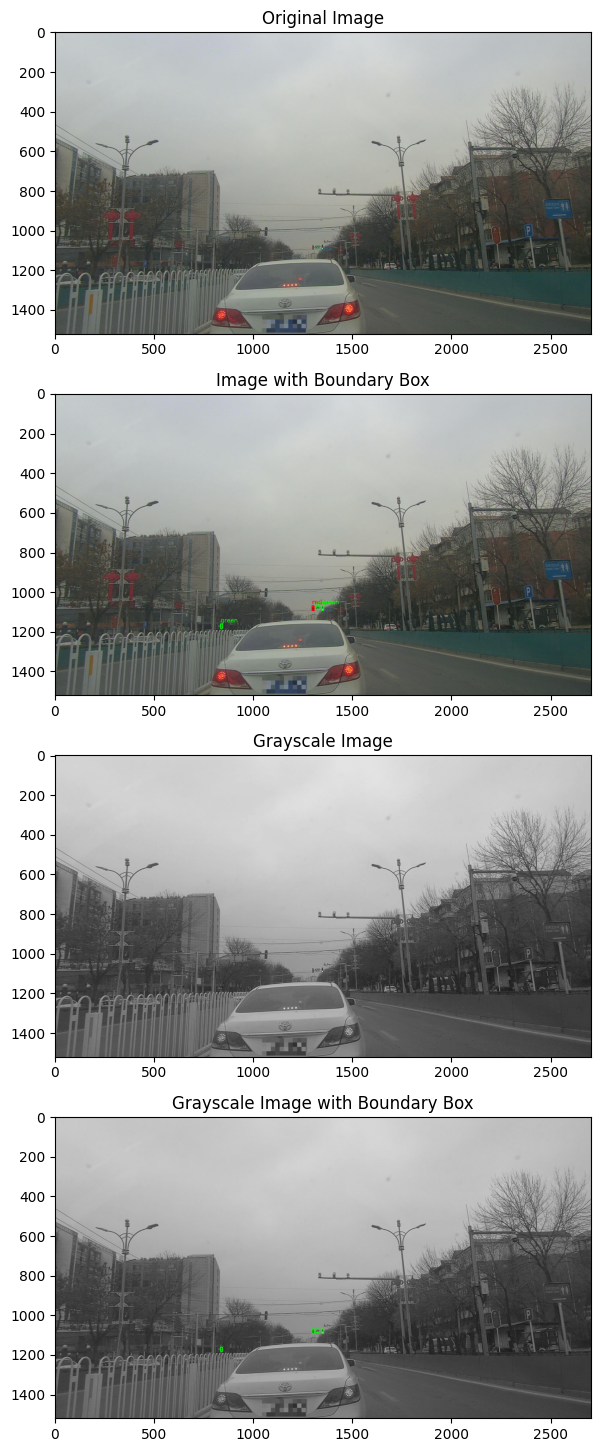

In [101]:
plot_img("00004.jpg")

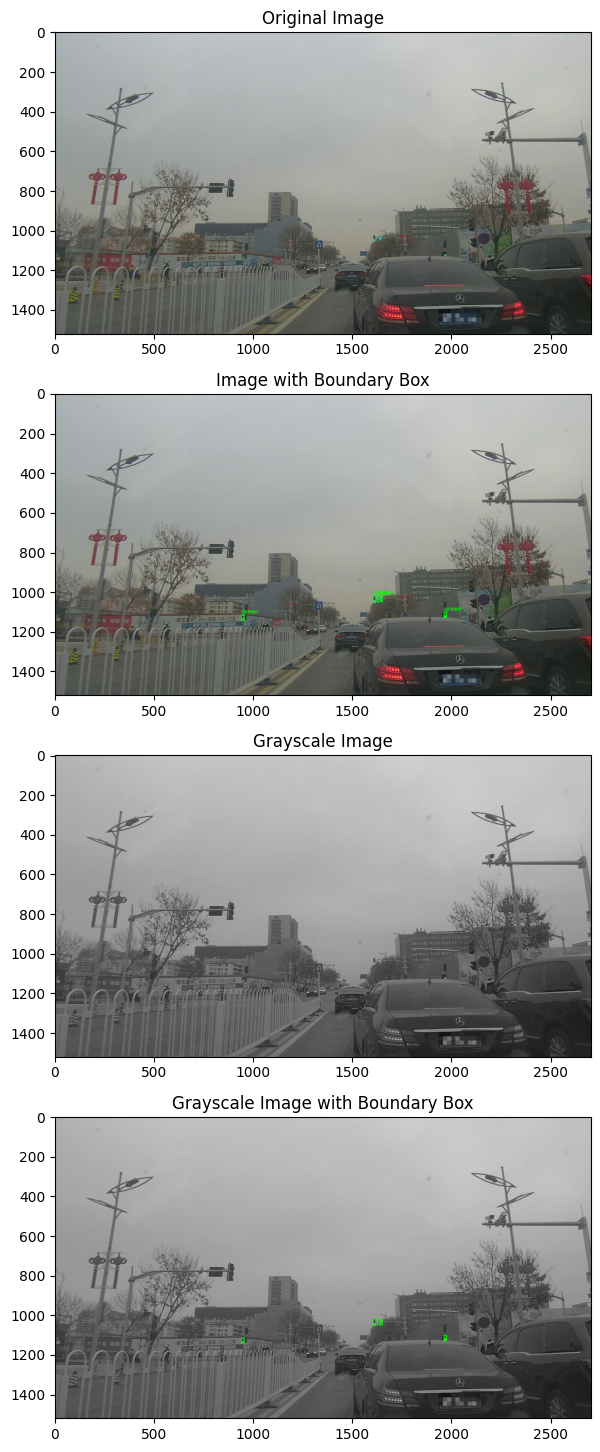

In [102]:
plot_img("00011.jpg")

In [14]:
_classes = np.insert(classes, 0, "background", axis=0)        
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class : 
 {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}


In [15]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

class TrafficLightDetectionDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):
        
        super().__init__()
        
        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor
        
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self, index: int):
        
        # Retrieve Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]
        
        # Loading Image
        image = cv2.imread(os.path.join(self.image_dir, image_name), cv2.IMREAD_UNCHANGED)

        # Check if the image has an alpha channel
        has_alpha_channel = image.shape[2] == 4

        # Convert BGR to RGB
        if not has_alpha_channel:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert RGB to grayscale for model input
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Check if the image is grayscale
        is_grayscale = len(image.shape) == 2

        if self.mode == 'train':
            
            # Get bounding box coordinates for each box
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            # Getting labels for each box
            temp_labels = records[['color']].values
            labels = [class_to_int[label[0]] for label in temp_labels]

            # Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            
            # Resize the image and the bounding boxes
            height, width = image_gray.shape[:2]
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image_gray = cv2.resize(image_gray, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            
            # Creating target
            target = {'boxes': boxes, 'labels': labels, 'area': torch.as_tensor(area, dtype=torch.float32)}

            # Transforms
            if self.transforms:
                image_gray = self.transforms(image_gray)

            return image_gray, target, image_name
        
        elif self.mode == 'test':
            # Resize the image
            height, width = image_gray.shape[:2]
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image_gray = cv2.resize(image_gray, (new_width, new_height))

            if self.transforms:
                image_gray = self.transforms(image_gray)

            return image_gray, image_name

# Assuming class_to_int is defined somewhere in your code
# class_to_int = {'red': 1, 'green': 2, 'yellow': 3}


In [16]:
# Preparing data for Train & Validation

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))


# Dataset object
dataset = TrafficLightDetectionDataset(df, DIR_IMAGES, transforms = get_transform())


# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-490])
valid_dataset = torch.utils.data.Subset(dataset, indices[-490:])


# Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [18]:
# Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [19]:
# Create / load model

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [20]:
# Preparing model for training

# Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]
# Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)
# LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
model.to(device)
# No of epochs
epochs = 5


In [21]:
# Training model

itr = 1
total_train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader):
        # tqdm 
        
        # Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())
        
        # Reseting Gradients
        optimizer.zero_grad()
        
        # Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        # Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        if itr % 300 == 0:
            print(f"\n Iteration #{itr} loss: {loss_value:.4f} \n") ## {out}
        itr += 1
    lr_scheduler.step() 

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")


 30%|███       | 300/990 [01:57<04:15,  2.70it/s]


 Iteration #300 loss: 0.7761 



 61%|██████    | 600/990 [03:48<02:24,  2.70it/s]


 Iteration #600 loss: 0.5964 



 91%|█████████ | 900/990 [05:39<00:33,  2.69it/s]


 Iteration #900 loss: 0.4624 



100%|██████████| 990/990 [06:13<00:00,  2.65it/s]


Epoch: 1
Epoch train loss is 0.6837
Time elapsed:  373.3579275608063


 21%|██        | 210/990 [01:18<04:48,  2.70it/s]


 Iteration #1200 loss: 0.5311 



 52%|█████▏    | 510/990 [03:09<02:57,  2.70it/s]


 Iteration #1500 loss: 0.5044 



 82%|████████▏ | 810/990 [05:00<01:06,  2.70it/s]


 Iteration #1800 loss: 0.2351 



100%|██████████| 990/990 [06:07<00:00,  2.69it/s]


Epoch: 2
Epoch train loss is 0.5379
Time elapsed:  367.59971356391907


 12%|█▏        | 120/990 [00:44<05:23,  2.69it/s]


 Iteration #2100 loss: 0.1859 



 42%|████▏     | 420/990 [02:36<03:32,  2.69it/s]


 Iteration #2400 loss: 0.2862 



 73%|███████▎  | 720/990 [04:27<01:40,  2.68it/s]


 Iteration #2700 loss: 0.3476 



100%|██████████| 990/990 [06:08<00:00,  2.69it/s]


Epoch: 3
Epoch train loss is 0.4459
Time elapsed:  368.2408685684204


  3%|▎         | 30/990 [00:11<05:57,  2.69it/s]


 Iteration #3000 loss: 0.4773 



 33%|███▎      | 330/990 [02:03<04:05,  2.69it/s]


 Iteration #3300 loss: 0.5012 



 64%|██████▎   | 630/990 [03:54<02:13,  2.69it/s]


 Iteration #3600 loss: 0.5873 



 94%|█████████▍| 930/990 [05:46<00:22,  2.69it/s]


 Iteration #3900 loss: 0.1795 



100%|██████████| 990/990 [06:08<00:00,  2.69it/s]


Epoch: 4
Epoch train loss is 0.4220
Time elapsed:  368.6200408935547


 24%|██▍       | 240/990 [01:29<04:39,  2.68it/s]


 Iteration #4200 loss: 0.3767 



 55%|█████▍    | 540/990 [03:20<02:46,  2.70it/s]


 Iteration #4500 loss: 0.4056 



 85%|████████▍ | 840/990 [05:11<00:55,  2.70it/s]


 Iteration #4800 loss: 0.6598 



100%|██████████| 990/990 [06:07<00:00,  2.69it/s]


Epoch: 5
Epoch train loss is 0.4016
Time elapsed:  367.69535088539124


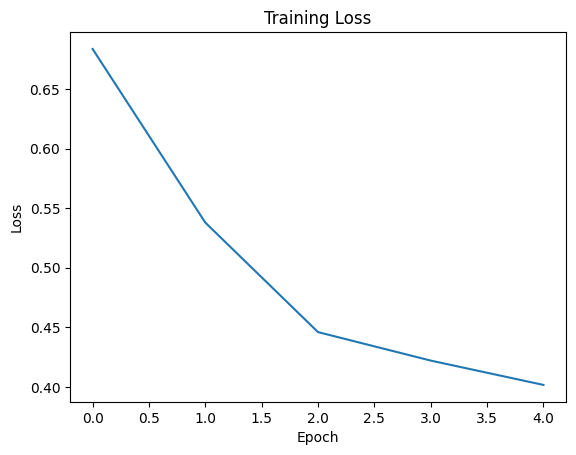

In [22]:
plt.plot(total_train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [23]:
itr = 1
v_loss = []

start_time = time.time()

for images, targets, image_names in tqdm(valid_data_loader):
        
    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
    #Forward propagation
    out = model(images, targets)
    losses = sum(loss for loss in out.values())
        
    #Average loss
    loss_value = losses.item()
    v_loss.append(loss_value)

val_loss = np.mean(v_loss)
print(f'Val loss is {val_loss:.4f}')
 
time_elapsed = time.time() - start_time
print("Time elapsed: ",time_elapsed)


100%|██████████| 245/245 [00:34<00:00,  7.06it/s]

Val loss is 0.4580
Time elapsed:  34.69157147407532


**BGR2RGB & RGB2CMY**

In [103]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def rgb_to_cmy(rgb_image):
    # Ensure input image is in the range [0, 1]
    rgb_image = np.clip(rgb_image, 0, 1)
    
    # Convert RGB to CMY
    cmy_image = 1 - rgb_image
    
    return cmy_image

def plot_img(image_name):
    
    fig, ax = plt.subplots(4, 1, figsize=(14, 18))  # Changed the number of subplots to 2x2
    ax = ax.flatten()
    
    bbox = df[df['filename'] == image_name]
    img_path = os.path.join(DIR_IMAGES, image_name)
    
    # Load the original image
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image_with_boxes = image.copy()  # Make a copy to preserve the original image
    
    # Plot the original image
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    # Plot the image with bounding boxes
    for idx, row in bbox.iterrows():
        x1 = int(row['xmin'])
        y1 = int(row['ymin'])
        x2 = int(row['xmax'])
        y2 = int(row['ymax'])
        label = row['color']
        if label == 'red':
            color = (1, 0, 0)  # CMY representation: (1 - R, 1 - G, 1 - B)
        elif label == 'green':
            color = (0, 1, 0)
        elif label == 'yellow':
            color = (0, 0, 1)
        
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), color, 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image_with_boxes, label, (x1, y1-10), font, 1, color, 2)
    
    ax[1].set_title('Image with Boundary Box')
    ax[1].imshow(image_with_boxes)
    
    # Convert the image to CMY color space
    cmy_image = rgb_to_cmy(image)
    
    # Plot the CMY image
    ax[2].set_title('CMY Image')
    ax[2].imshow(cmy_image)

    # Plot the CMY image with bounding boxes
    cmy_image_with_boxes = rgb_to_cmy(image_with_boxes)
    for idx, row in bbox.iterrows():
        x1 = int(row['xmin'])
        y1 = int(row['ymin'])
        x2 = int(row['xmax'])
        y2 = int(row['ymax'])
        cv2.rectangle(cmy_image_with_boxes, (x1, y1), (x2, y2), color, 3)
    
    ax[3].set_title('CMY Image with Boundary Box')
    ax[3].imshow(cmy_image_with_boxes)

    plt.show()


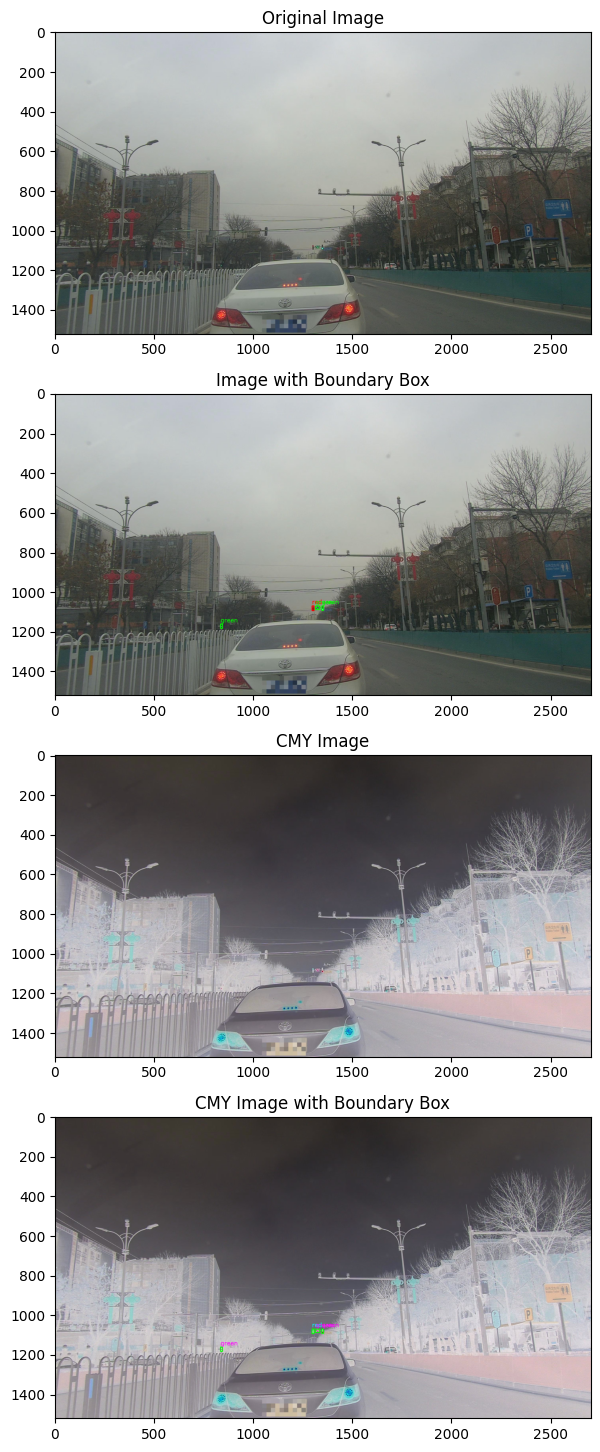

In [104]:
plot_img("00004.jpg")

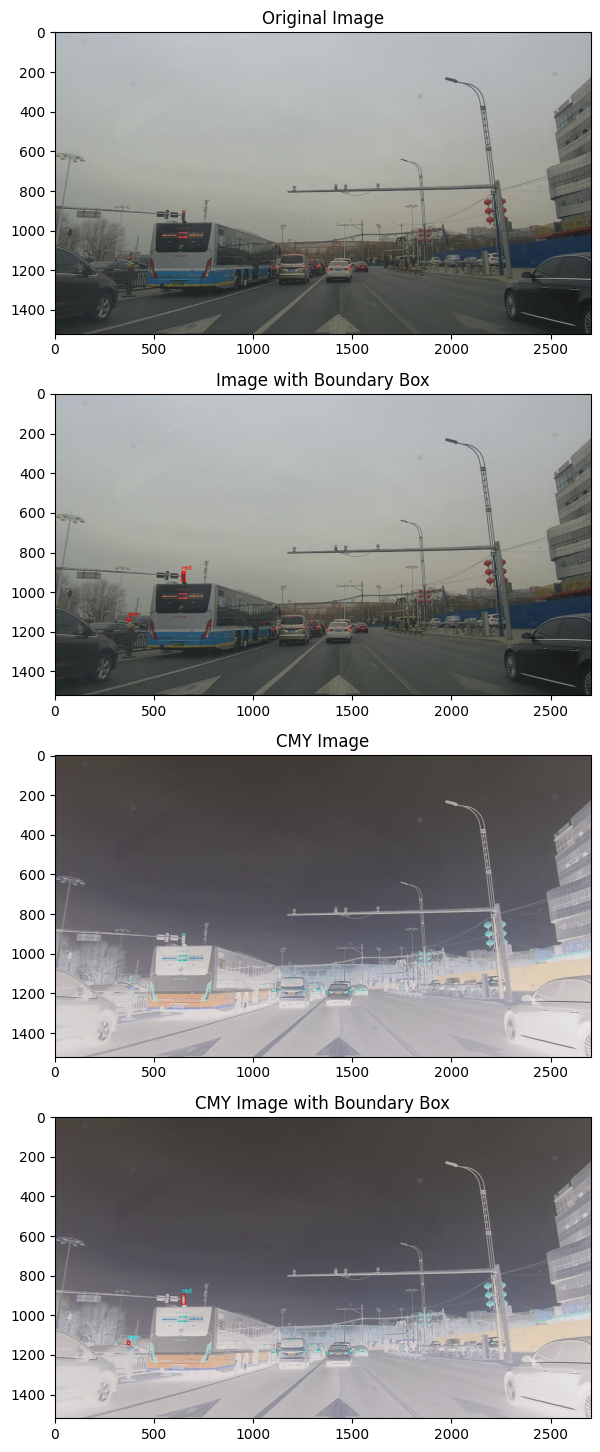

In [105]:
plot_img('00025.jpg')

In [81]:
_classes = np.insert(classes, 0, "background", axis=0)        
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'red': 1, 'green': 2, 'yellow': 3}

int_to_class : 
 {0: 'background', 1: 'red', 2: 'green', 3: 'yellow'}


In [82]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

class TrafficLightDetectionDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, mode='train', transforms=None, resize_factor=0.25):
        
        super().__init__()
        
        self.image_names = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        self.resize_factor = resize_factor
        
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self, index: int):
        
        # Retrieve Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df['filename'] == image_name]
        
        # Loading Image
        image = cv2.imread(os.path.join(self.image_dir, image_name), cv2.IMREAD_UNCHANGED)

        # Check if the image has an alpha channel
        has_alpha_channel = image.shape[2] == 4

        # Convert BGR to RGB
        if not has_alpha_channel:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert RGB to CMY manually
        image_cmy = 255 - image  # CMY = 255 - RGB

        if self.mode == 'train':
            
            # Get bounding box coordinates for each box
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

            # Getting labels for each box
            temp_labels = records[['color']].values
            labels = [class_to_int[label[0]] for label in temp_labels]

            # Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            
            # Resize the image and the bounding boxes
            height, width = image_cmy.shape[:2]
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image_cmy = cv2.resize(image_cmy, (new_width, new_height))
            boxes = boxes * self.resize_factor
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            
            # Creating target
            target = {'boxes': boxes, 'labels': labels, 'area': torch.as_tensor(area, dtype=torch.float32)}

            # Transforms
            if self.transforms:
                image_cmy = self.transforms(image_cmy)

            return image_cmy, target, image_name
        
        elif self.mode == 'test':
            # Resize the image
            height, width = image_cmy.shape[:2]
            new_height, new_width = int(height * self.resize_factor), int(width * self.resize_factor)
            image_cmy = cv2.resize(image_cmy, (new_width, new_height))

            if self.transforms:
                image_cmy = self.transforms(image_cmy)

            return image_cmy, image_name

# Assuming class_to_int is defined somewhere in your code
# class_to_int = {'red': 1, 'green': 2, 'yellow': 3}


In [83]:
# Preparing data for Train & Validation

def get_transform():
    return T.Compose([T.ToTensor()])

def collate_fn(batch):
    return tuple(zip(*batch))


# Dataset object
dataset = TrafficLightDetectionDataset(df, DIR_IMAGES, transforms = get_transform())


# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-490])
valid_dataset = torch.utils.data.Subset(dataset, indices[-490:])


# Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 2,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)

In [84]:
# Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [85]:
# Create / load model

# Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [86]:
# Preparing model for training

# Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]
# Defininig Optimizer
optimizer = torch.optim.Adam(params, lr = 0.0001)
# LR
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
model.to(device)
# No of epochs
epochs = 5

In [87]:
# Training model

itr = 1
total_train_loss = []
for epoch in range(epochs):
    start_time = time.time()
    train_loss = []
    for images, targets, image_names in tqdm(train_data_loader):
        # tqdm 
        
        # Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())
        
        # Reseting Gradients
        optimizer.zero_grad()
        
        # Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        # Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        if itr % 300 == 0:
            print(f"\n Iteration #{itr} loss: {loss_value:.4f} \n") ## {out}
        itr += 1
    lr_scheduler.step() 

    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch: {epoch+1}')
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            }, "checkpoint.pth")


 30%|███       | 300/990 [01:51<04:15,  2.70it/s]


 Iteration #300 loss: 1.5697 



 61%|██████    | 600/990 [03:43<02:25,  2.68it/s]


 Iteration #600 loss: 0.5910 



 91%|█████████ | 900/990 [05:35<00:33,  2.68it/s]


 Iteration #900 loss: 1.2896 



100%|██████████| 990/990 [06:08<00:00,  2.69it/s]


Epoch: 1
Epoch train loss is 0.6614
Time elapsed:  368.6171886920929


 21%|██        | 210/990 [01:18<04:51,  2.67it/s]


 Iteration #1200 loss: 0.2414 



 52%|█████▏    | 510/990 [03:10<02:58,  2.69it/s]


 Iteration #1500 loss: 0.6383 



 82%|████████▏ | 810/990 [05:02<01:06,  2.69it/s]


 Iteration #1800 loss: 0.9660 



100%|██████████| 990/990 [06:09<00:00,  2.68it/s]


Epoch: 2
Epoch train loss is 0.5055
Time elapsed:  369.35546135902405


 12%|█▏        | 120/990 [00:44<05:23,  2.69it/s]


 Iteration #2100 loss: 0.3647 



 42%|████▏     | 420/990 [02:36<03:33,  2.67it/s]


 Iteration #2400 loss: 0.3149 



 73%|███████▎  | 720/990 [04:28<01:41,  2.66it/s]


 Iteration #2700 loss: 0.3753 



100%|██████████| 990/990 [06:09<00:00,  2.68it/s]


Epoch: 3
Epoch train loss is 0.4168
Time elapsed:  369.37226128578186


  3%|▎         | 30/990 [00:11<05:58,  2.68it/s]


 Iteration #3000 loss: 0.1981 



 33%|███▎      | 330/990 [02:03<04:05,  2.69it/s]


 Iteration #3300 loss: 0.3822 



 64%|██████▎   | 630/990 [03:55<02:14,  2.67it/s]


 Iteration #3600 loss: 0.2689 



 94%|█████████▍| 930/990 [05:47<00:22,  2.67it/s]


 Iteration #3900 loss: 0.6483 



100%|██████████| 990/990 [06:09<00:00,  2.68it/s]


Epoch: 4
Epoch train loss is 0.3921
Time elapsed:  369.51389622688293


 24%|██▍       | 240/990 [01:29<04:39,  2.68it/s]


 Iteration #4200 loss: 0.1925 



 55%|█████▍    | 540/990 [03:21<02:47,  2.68it/s]


 Iteration #4500 loss: 0.1364 



 85%|████████▍ | 840/990 [05:13<00:56,  2.67it/s]


 Iteration #4800 loss: 0.3603 



100%|██████████| 990/990 [06:09<00:00,  2.68it/s]


Epoch: 5
Epoch train loss is 0.3728
Time elapsed:  369.3945174217224


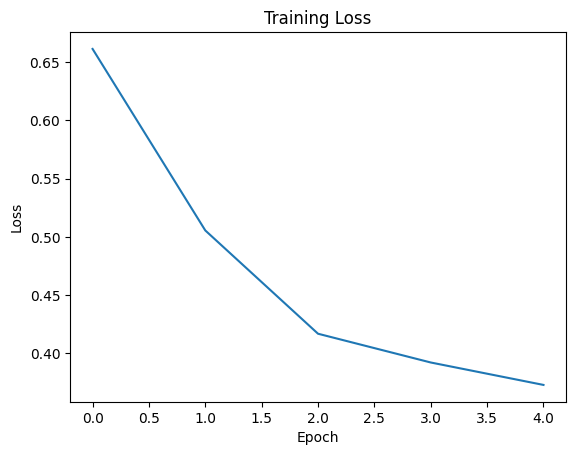

In [88]:
plt.plot(total_train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [89]:
itr = 1
v_loss = []

start_time = time.time()

for images, targets, image_names in tqdm(valid_data_loader):
        
    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
    #Forward propagation
    out = model(images, targets)
    losses = sum(loss for loss in out.values())
        
    #Average loss
    loss_value = losses.item()
    v_loss.append(loss_value)

val_loss = np.mean(v_loss)
print(f'Val loss is {val_loss:.4f}')
 
time_elapsed = time.time() - start_time
print("Time elapsed: ",time_elapsed)


100%|██████████| 245/245 [00:35<00:00,  6.98it/s]

Val loss is 0.4097
Time elapsed:  35.09327411651611
